# King County Real Estate Sales

## Initial Data Import & Review

In [6]:
#Import Libraries
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [7]:
df = pd.read_csv("kc_house_data.csv")  

#drop presumptively irrelevant columns (viewed, prop. id, and date sold)
df = df.loc(axis=1)['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                    'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 
                    'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 
                    'sqft_living15', 'sqft_lot15', 'lat', 'long']
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,lat,long
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,0.0,98178,1340,5650,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,1690,7639,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,NaN,98028,2720,8062,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,1360,5000,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,1800,7503,47.6168,-122.045


## How Are the Properties Distributed? 

### How is the data geographically spread across King County, WA? 

In [8]:
#Create price-per-square-foot variable to show how prices per square foot vary
#over the county.
df['price_sqft'] = df['price']/df['sqft_living']

In [9]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,lat,long,price_sqft
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,1986.620318,12758.283512,47.560093,-122.213982,264.143368
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,685.230472,27274.441950,0.138552,0.140724,110.000061
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,399.000000,651.000000,47.155900,-122.519000,87.588235
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,1490.000000,5100.000000,47.471100,-122.328000,182.291667
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,1840.000000,7620.000000,47.571800,-122.231000,244.644550
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,2360.000000,10083.000000,47.678000,-122.125000,318.333333
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,6210.000000,871200.000000,47.777600,-121.315000,810.138889


In [10]:
KCo_map = gpd.read_file('King_County_Political_Boundary_no_waterbodies__kingco_area.shp')
crs = {'init':'espc:4326'}
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

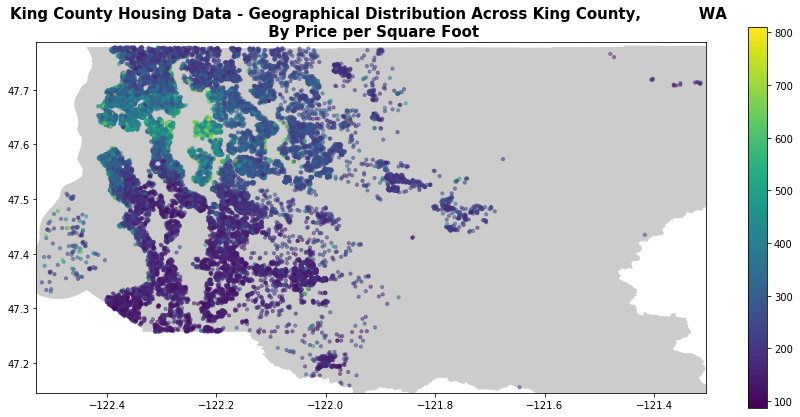

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
KCo_map.plot(ax=ax, alpha=0.4,color='grey')
geo_df.plot(column=df['price_sqft'],ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title('King County Housing Data - Geographical Distribution Across King County, \
          WA \n By Price per Square Foot', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(df.long.min()-0.01,df.long.max()+0.01)
plt.ylim(df.lat.min()-0.01, df.lat.max()+0.01)

plt.show()

The data set mostly includes western King County (the Seattle area), though there area few sales from the more rural areas to the east).  The higher price-per-square-foot areas are focused on the down-town Seattle area, while the lower-priced areas are spread outside of this area.

## How does price per square foot vary by zip code?  

Do the zip codes contain any predictive value based upon the properties' price per square foot? 

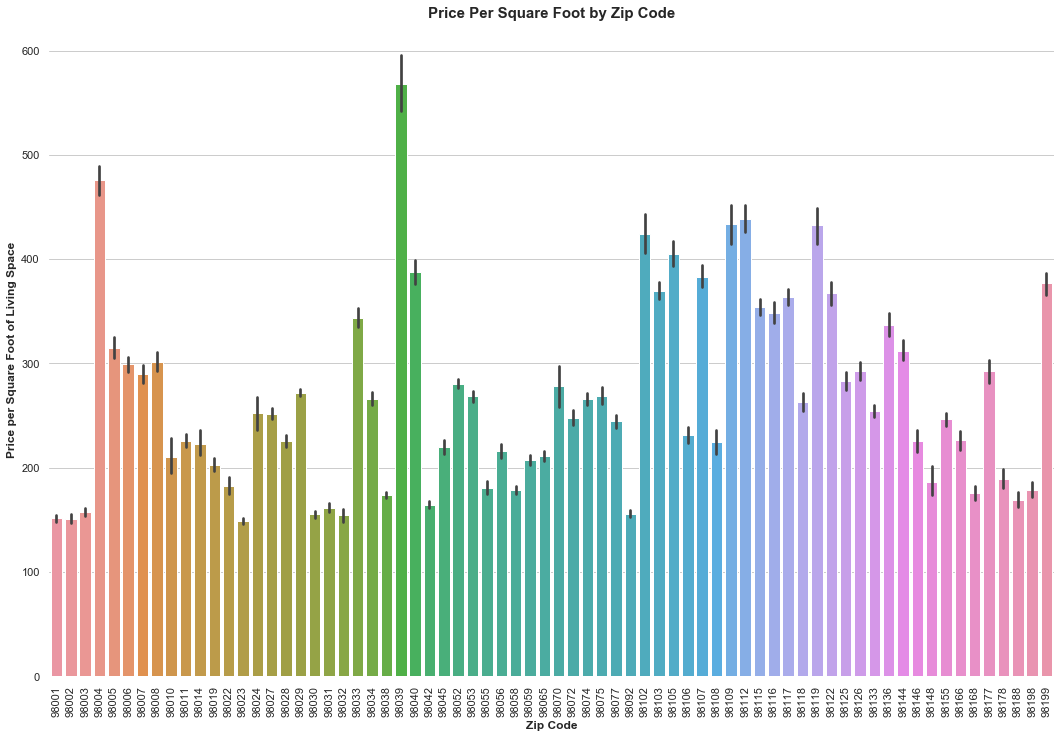

In [12]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.color_palette("muted")

f, ax = plt.subplots(figsize=(18, 12))
sns.despine(f, left=True, bottom=True)
sns.barplot(x="zipcode", y="price_sqft", data=df, ax=ax)
ax.set_title("Price Per Square Foot by Zip Code", fontsize=15,fontweight='bold')
ax.set_xlabel("Zip Code", fontsize=12,fontweight='bold')
ax.set_ylabel("Price per Square Foot of Living Space", fontsize=12,fontweight='bold')
plt.xticks(rotation=90)

plt.show()

Price per square foot varies greatly by zip code.  Which specific ones are higher or lower doesn't matter as much as the fact that they're significantly different; the zip codes are going to be significant categorical predictors.

## Further Data Review:

#### Review descriptive statistics, value counts for each column, along with min/max of each:

In [13]:
#drop columns only used for the above visualizations
df.drop(columns = ['lat', 'long', 'geometry', 'price_sqft'], inplace = True)

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,6210.000000,871200.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(5), int64(10), object(1)
memory usage: 2.6+ MB


In [15]:
for col in df.columns:  
    print(col, '\n', df[col].value_counts(normalize=True).head(20), 
    '\n Min:', df[col].min(), '  Max:', df[col].max(), 
    'Unique Values:', df[col].nunique(),'\n')

price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
325000.0    0.006853
400000.0    0.006714
375000.0    0.006390
300000.0    0.006158
525000.0    0.006066
250000.0    0.006019
475000.0    0.005556
330000.0    0.005510
650000.0    0.005417
275000.0    0.005232
415000.0    0.005140
315000.0    0.005140
390000.0    0.005093
600000.0    0.005093
440000.0    0.005047
Name: price, dtype: float64 
 Min: 78000.0   Max: 7700000.0 Unique Values: 3622 

bedrooms 
 3     0.454878
4     0.318655
2     0.127796
5     0.074131
6     0.012594
1     0.009075
7     0.001760
8     0.000602
9     0.000278
10    0.000139
11    0.000046
33    0.000046
Name: bedrooms, dtype: float64 
 Min: 1   Max: 33 Unique Values: 12 

bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
1.50    0.066907
2.75    0.054869
3.00    0.034866
3.50    0.033847
3.25    0.027272
3.75    0.007177
4.00    0.006297
4.50    0.004

#### Examine the data for the presence and quantity of NaN entries:

In [16]:
df.isna().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront        True
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated      True
zipcode          False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [17]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### Analysis of Results: 
NaN entries appear in the waterfront column and the yr_renovated column.  For waterfront, the vast majority (over 99%) are "0.0".  While the waterfront homes are in the minority, they will likely play a significant role in the ultimate value of a home (though we'll determine this when selecting the most predictive features for the model).  Accordingly, I don't think we're skewing the data to significantly at all to change the NaN entries to "0.0."  

In contrast, the "yr_renovated" series is all over the place.  The vast majority (~96%) are "0.0," suggesting that they were never renovated (or there is no data on a renovation), and that it likely will not have a beneficial effect on the ultimate model.  Accordingly, I believe it would be best to drop this column. 

The high bedrooms (33) is clearly an outlier, but there are also other entries with between 7-11 bedrooms.  Those houses with 1-6 bedrooms make up 99.7129% of the properties reviewed; considering the relative rarity for houses with more than six bedrooms, it makes sense to limit the dataset to properties with six for fewer bedrooms.  

The sqft_basement has a placeholder ("?") and the vast majority of the properties did not have a basement. Also, the column is of type "object," which will not work in the regression.  As such, we'll covert the placeholder into 0.0 and convert the series type into float64. 

#### Cleaning up NaNs in Waterfront and Yr_Renovated, Converting Sqft_basement's Problems, and Limiting Data to 6 and Fewer Bedrooms:

In [18]:
#replace waterfront NaNs with 0.0
df['waterfront'].fillna(value = 0.0, inplace = True)

df.drop(columns = ['yr_renovated'], inplace = True)

#limit dataset to properties with less than six bedrooms
df = df.loc[df['bedrooms'] < 7.0]

#converting sqft_basement placeholders and then series type
df.sqft_basement.replace('?', 0.0, inplace=True)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
count,2.153500e+04,21535.000000,21535.000000,21535.000000,2.153500e+04,21535.000000,21535.000000,21535.000000,21535.000000,21535.000000,21535.000000,21535.000000,21535.000000,21535.000000,21535.000000
mean,5.390889e+05,3.359786,2.111400,2075.221779,1.509742e+04,1.493360,0.006780,3.409705,7.656280,1785.243836,284.044161,1971.039053,98077.929557,1985.835663,12759.793220
std,3.652086e+05,0.875090,0.762291,909.693683,4.142101e+04,0.539494,0.082061,0.650431,1.171862,823.245932,437.132158,29.359903,53.523854,684.596314,27274.117437
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,98001.000000,399.000000,651.000000
25%,3.210000e+05,3.000000,1.750000,1420.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,98033.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.615000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,98065.000000,1840.000000,7620.000000
75%,6.430000e+05,4.000000,2.500000,2540.000000,1.066750e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,540.000000,1997.000000,98118.000000,2360.000000,10081.500000
max,7.700000e+06,6.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,98199.000000,6210.000000,871200.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21535 entries, 0 to 21596
Data columns (total 15 columns):
price            21535 non-null float64
bedrooms         21535 non-null int64
bathrooms        21535 non-null float64
sqft_living      21535 non-null int64
sqft_lot         21535 non-null int64
floors           21535 non-null float64
waterfront       21535 non-null float64
condition        21535 non-null int64
grade            21535 non-null int64
sqft_above       21535 non-null int64
sqft_basement    21535 non-null float64
yr_built         21535 non-null int64
zipcode          21535 non-null int64
sqft_living15    21535 non-null int64
sqft_lot15       21535 non-null int64
dtypes: float64(5), int64(10)
memory usage: 2.6 MB


### Confirm NaN Entries Have Been Addressed:

In [20]:
df.isna().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
zipcode          False
sqft_living15    False
sqft_lot15       False
dtype: bool

## Further data review via Matrix:
Looking for other non-categorical variables which do not appear to have any predictive qualities and which may be categorical, needing one-hot encoding. 

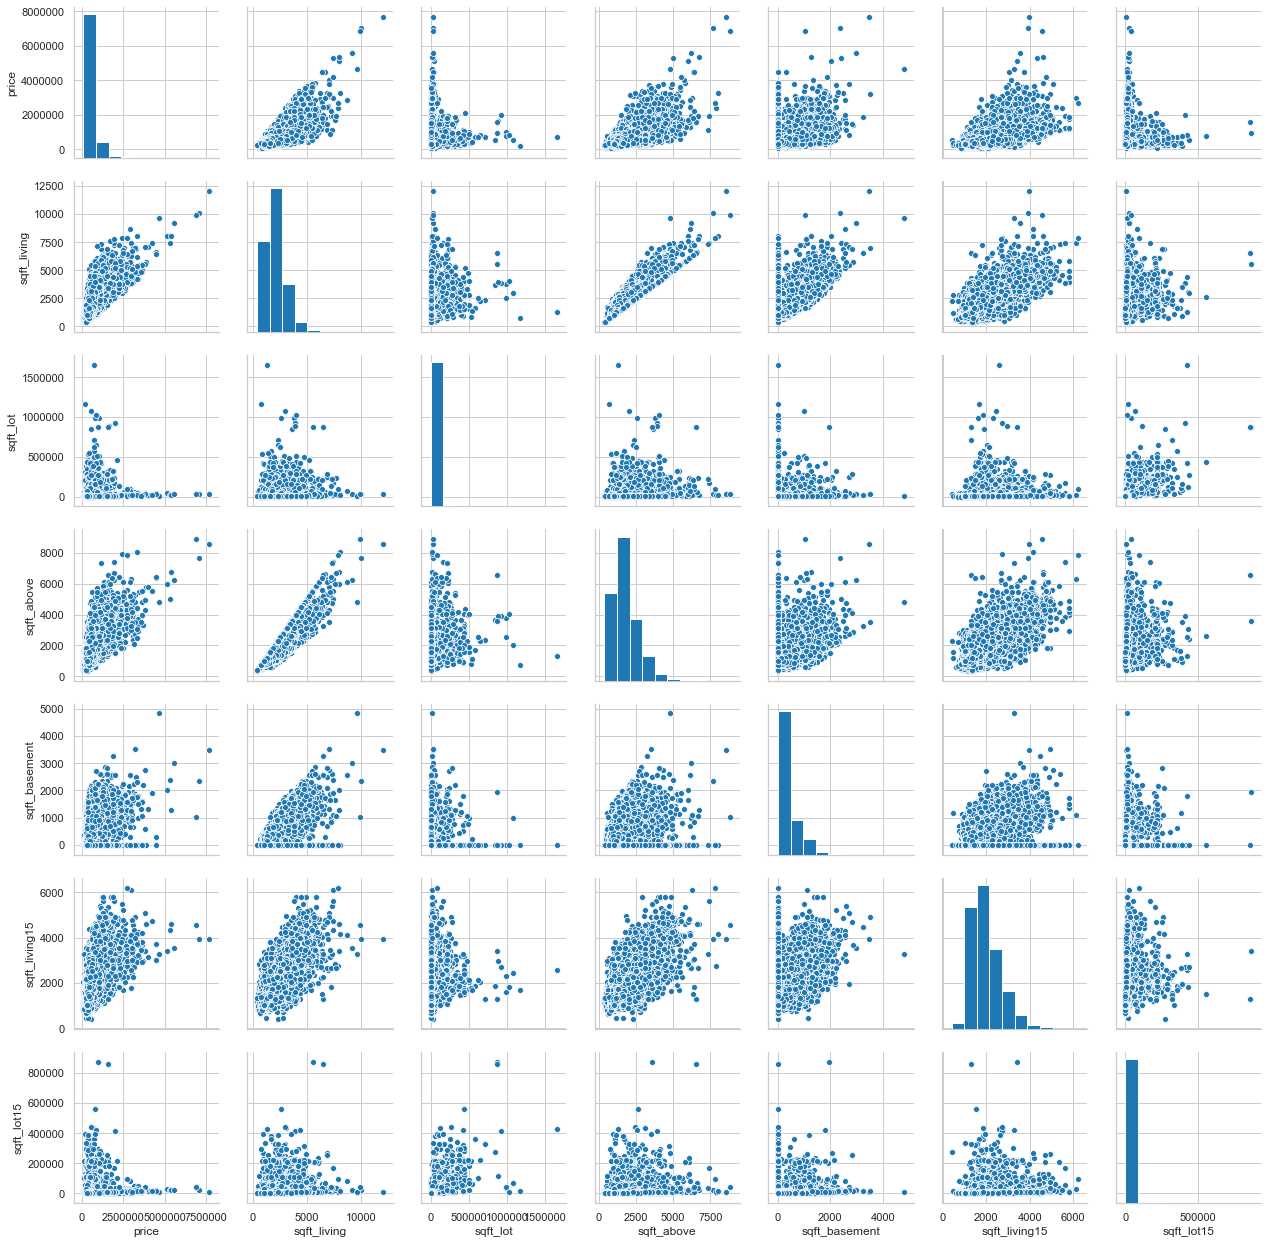

In [21]:
sns.pairplot(df[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                 'sqft_living15', 'sqft_lot15']])
plt.show()

## Matrix Review / Addressing Categorical Variables:

The matrix also shows a number of potential categorical variables: **bedrooms, bathrooms, floors, waterfront, condition, and grade**. While thse look categorical, they are ordinal and should be treated as continuous.  The truly categorical variables are **waterfront** and **zipcode**.  Since **waterfront** is already binary, it doesn't need to be changed; **zipcode** will be converted using one-hot encoding. 

The non-categorical variables generally display adequate linearity, with the exceptions of **yr_built, sqft_lot, and sqft_lot15**. None of these were ultimately used in the model.  

First, we'll create the dummy variables for the dummy variables:

In [22]:
zipcode_dummies = pd.get_dummies(df['zipcode'], prefix='zip', drop_first=True)

In [23]:
df = df.drop(['zipcode'], axis=1)
df = pd.concat([df, zipcode_dummies], axis=1)

## Check for Multicollinearity:
(Using a 75% cutoff and Heatmap)

In [24]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'waterfront']].corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,waterfront
price,1.000000,0.313566,0.525273,0.701430,0.089269,0.254498,0.034651,0.667514,0.603433,0.318457,0.056726,0.584767,0.082208,0.266527
bedrooms,0.313566,1.000000,0.523199,0.593303,0.034940,0.183149,0.024199,0.373691,0.493839,0.297263,0.173813,0.414222,0.033682,-0.000989
bathrooms,0.525273,0.523199,1.000000,0.753889,0.087239,0.504106,-0.126711,0.668597,0.684786,0.272390,0.514249,0.572510,0.087315,0.064761
sqft_living,0.701430,0.593303,0.753889,1.000000,0.171603,0.352717,-0.060469,0.765086,0.875747,0.422471,0.323749,0.759180,0.182574,0.106220
sqft_lot,0.089269,0.034940,0.087239,0.171603,1.000000,-0.005553,-0.008632,0.113781,0.182659,0.012571,0.052504,0.143796,0.717488,0.021489
floors,0.254498,0.183149,0.504106,0.352717,-0.005553,1.000000,-0.265328,0.458338,0.523592,-0.246646,0.492021,0.279065,-0.011541,0.020947
condition,0.034651,0.024199,-0.126711,-0.060469,-0.008632,-0.265328,1.000000,-0.148193,-0.160716,0.170470,-0.361727,-0.094174,-0.003004,0.016690
grade,0.667514,0.373691,0.668597,0.765086,0.113781,0.458338,-0.148193,1.000000,0.756987,0.163035,0.450041,0.713211,0.119969,0.083148
sqft_above,0.603433,0.493839,0.684786,0.875747,0.182659,0.523592,-0.160716,0.756987,1.000000,-0.059468,0.428716,0.732950,0.193639,0.072612
sqft_basement,0.318457,0.297263,0.272390,0.422471,0.012571,-0.246646,0.170470,0.163035,-0.059468,1.000000,-0.130241,0.197177,0.013412,0.083998


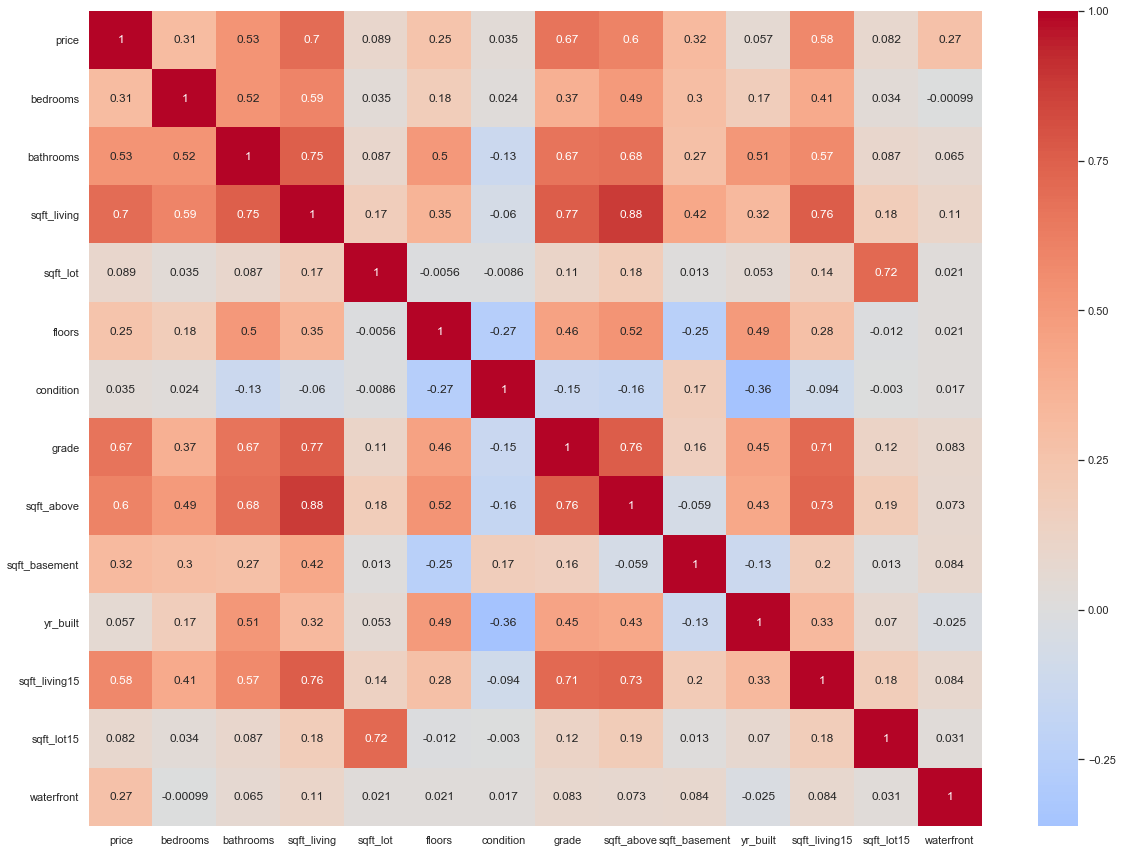

In [25]:
plt.subplots(figsize=(20,15))
sns.heatmap(df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'waterfront']].corr(), center=0,annot=True, cmap='coolwarm')
plt.show()

### Analysis:

The largest multicollinearity lies between **sqft_living** and **sqft_above (0.88)**.  To a lesser extent, there was some multicollinearity between **sqft_living** and **sqft_living15** (between the living space of the house in question and the 15 closest neighbors), as well as **sqft_living** and **grade (0.77)** and **sqft_above** and **grade (0.76)**.  With regard to the first relationship, **sqft_living** has a 0.70 correlation with the target variable, **price**, while **sqft_above** only has a 0.60 correlation; this suggests we should drop **sqft_above**.  This may also remove the multicollinearity between **sqft_above** and **grade**. Considering the strength of the **sqft_living** variable, it would also make sense to drop **sqft_living15**.  The **grade** variable has a strong correlation with **price**, so despite the collinearity with **sqft_living**, I'll leav it in for now. Finally, it just doesn't make logical sense to keep the neighbors' lot sizes if we're dropping their living space square footage; accordingly, we'll drop that variable (**sqft_lot15**), as well as the preceding three. 

In [26]:
df = df.drop(['sqft_above', 'sqft_living15', 'sqft_lot15'], axis = 1)

In [27]:
df.info() #Ensure those columns were dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21535 entries, 0 to 21596
Data columns (total 80 columns):
price            21535 non-null float64
bedrooms         21535 non-null int64
bathrooms        21535 non-null float64
sqft_living      21535 non-null int64
sqft_lot         21535 non-null int64
floors           21535 non-null float64
waterfront       21535 non-null float64
condition        21535 non-null int64
grade            21535 non-null int64
sqft_basement    21535 non-null float64
yr_built         21535 non-null int64
zip_98002        21535 non-null uint8
zip_98003        21535 non-null uint8
zip_98004        21535 non-null uint8
zip_98005        21535 non-null uint8
zip_98006        21535 non-null uint8
zip_98007        21535 non-null uint8
zip_98008        21535 non-null uint8
zip_98010        21535 non-null uint8
zip_98011        21535 non-null uint8
zip_98014        21535 non-null uint8
zip_98019        21535 non-null uint8
zip_98022        21535 non-null uint8
zip_980

## Matrix Review / Normality of Feature Distribution

The following features do not appear to be normally distributed in the matrix above: sqft_living, sqft_lot, and sqft_lot_15 (this has been dropped, so it won't be addressed further).  

The price variable has a long tail, illustrating that the home sales have a natural midpoint, and then extend into the luxury end as well. I'll take a closer look at the price feature below, and consider log-transformation vs. narrowing the scope of our model.  

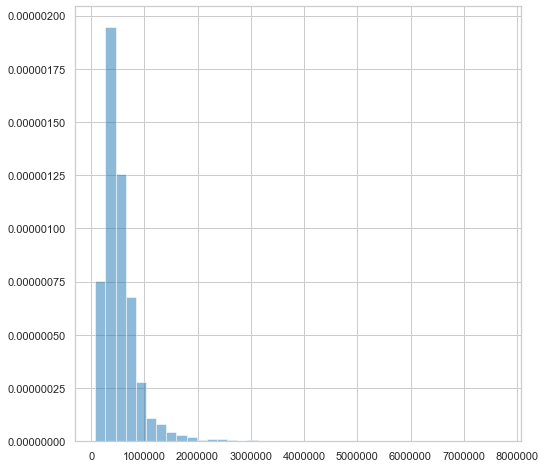

In [28]:
#Repeat histogram on price: 
price_hist = plt.figure(num=1, figsize=(8,8))
ax = price_hist.add_subplot(111)
ax.hist(df['price'], bins = 40, density = True, alpha = 0.5)
plt.show()

There is a relatively normal distribution of price up to approximately $600,000.  To keep the model as simple as possible, and because our approach is generally more aimed at middle to upper-middle-class homes, I think it would make sense to limit the model to include data from sales above 200,000 and below 600,000. 

In [29]:
df = df.loc[df['price'] > 200000]
df = df.loc[df['price'] < 600000]
df.describe() 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,yr_built,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
count,14370.000000,14370.000000,14370.000000,14370.000000,1.437000e+04,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.0,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.00000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000,14370.000000
mean,389270.376409,3.222895,1.943963,1777.647530,1.295686e+04,1.429019,0.001253,3.391301,7.273486,230.001601,1971.285247,0.010160,0.017049,0.000278,0.002227,0.009812,0.005567,0.012526,0.004802,0.011413,0.006193,0.012109,0.014057,0.029436,0.003688,0.016493,0.017049,0.012317,0.016632,0.018372,0.007307,0.010786,0.030967,0.037648,0.0,0.000626,0.033820,0.013152,0.018580,0.012526,0.016284,0.023034,0.028671,0.026096,0.015240,0.006124,0.012596,0.012526,0.004384,0.005567,0.021712,0.002018,0.024774,0.005846,0.020807,0.012665,0.012039,0.001670,0.002923,0.022895,0.013709,0.024983,0.028184,0.003201,0.011134,0.02380,0.020946,0.032777,0.012874,0.015936,0.014823,0.003340,0.027557,0.013500,0.013570,0.009951,0.014405,0.007864,0.015310,0.008212
std,107167.215609,0.828584,0.648716,609.156809,3.189744e+04,0.537843,0.035371,0.628765,0.798478,367.371966,28.056461,0.100287,0.129460,0.016682,0.047139,0.098572,0.074408,0.111221,0.069130,0.106222,0.078457,0.109374,0.117730,0.169032,0.060621,0.127365,0.129460,0.110302,0.127892,0.134296,0.085170,0.103299,0.173235,0.190350,0.0,0.025019,0.180773,0.113931,0.135042,0.111221,0.126570,0.150017,0.166885,0.159426,0.122511,0.078018,0.111525,0.111221,0.066070,0.074408,0.145746,0.044879,0.155441,0.076235,0.142744,0.111829,0.109064,0.040835,0.053985,0.149574,0.116285,0.156077,0.165503,0.056490,0.104934,0.15243,0.143210,0.178058,0.112735,0.125232,0.120846,0.057701,0.163707,0.115408,0.115701,0.099262,0.119157,0.088331,0.122786,0.090248
min,200126.000000,1.000000,0.500000,370.000000,5.720000e+02,1.000000,0.000000,1.000000,3.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

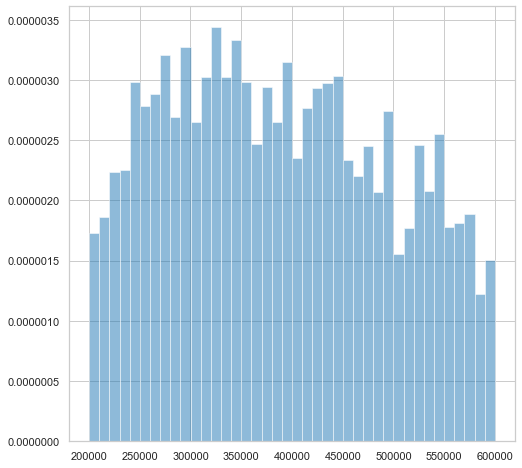

In [30]:
#Repeat histogram on price: 
price_hist = plt.figure(num=1, figsize=(8,8))
ax = price_hist.add_subplot(111)
ax.hist(df['price'], bins = 40, density = True, alpha = 0.5)
plt.show()

#### Analysis:
When limiting the dataset to prices between \\$200,000 and \\$600,000, the mean and median come much closer together and the data appears to be more evenly distributed.  Limiting the scope of the model by price appears to be a good move. 

The pairplot matrix will be run once more to explore how limiting the scope has affected the other variables. 

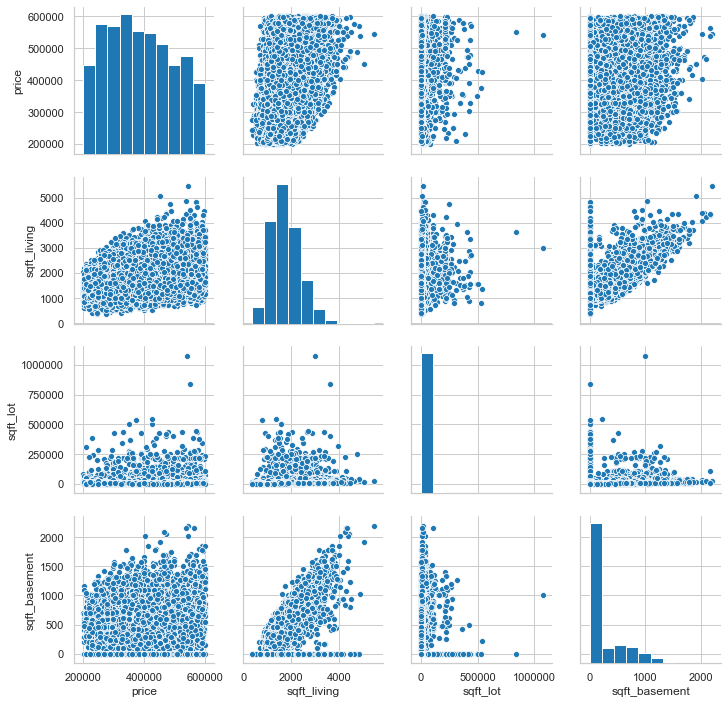

In [31]:
sns.pairplot(df[['price', 'sqft_living', 'sqft_lot', 'sqft_basement']])
plt.show()

The **sqft_living** feature's distribution seems to resemble the very slight skew of **price**, but **sqft_lot** may benefit from log transformation.

In [32]:
df['log_sqft_lot'] = df['sqft_lot'].copy()
df['log_sqft_lot'] = df['log_sqft_lot'].map(lambda x: np.log(x))

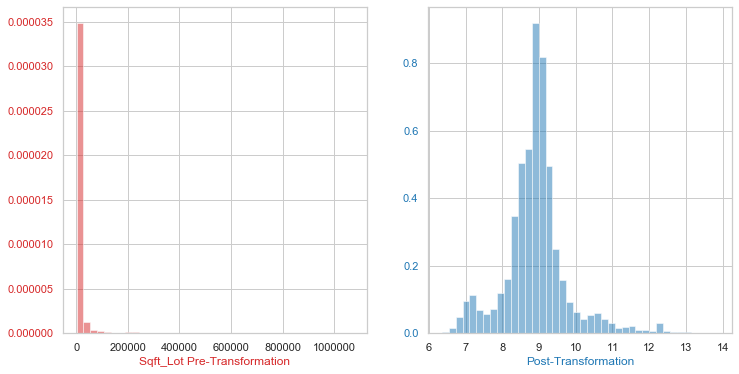

In [33]:
#Visualize change in distribution from log transformation

newfig = plt.figure(num=2, figsize = (12,6))
ax_pre = newfig.add_subplot(1,2,1)
ax_post = newfig.add_subplot(1,2,2)
    
color = 'tab:red'
ax_pre.set_xlabel(('Sqft_Lot Pre-Transformation'),  color=color)
ax_pre.hist(df['sqft_lot'], bins=40, density = True, alpha = 0.5, color=color)
ax_pre.tick_params(axis='y', labelcolor=color)
    
color2 = 'tab:blue'
ax_post.set_xlabel(('Post-Transformation'), color=color2)
ax_post.hist(df['log_sqft_lot'], bins=40, density = True,  alpha = 0.5, color=color2)
ax_post.tick_params(axis='y', labelcolor=color2)

plt.show()

#### Review: 

Log-transformation helped normalize the distribution of **log_sqft_lot** so the original dropped. 

In [34]:
df.drop(columns = ['sqft_lot'], inplace = True)
df.head(2)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,sqft_basement,yr_built,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,log_sqft_lot
0,221900.0,3,1.00,1180,1.0,0.0,3,7,0.0,1955,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8.639411
1,538000.0,3,2.25,2570,2.0,0.0,3,7,400.0,1951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.887653


### Review Multicollinearity Following Scope Limitation and Log-Transformation:

In [35]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df[['price', 'bedrooms', 'sqft_living', 'log_sqft_lot', 'floors',
       'condition', 'sqft_basement', 'yr_built', 'waterfront']].corr()

,price,bedrooms,sqft_living,log_sqft_lot,floors,condition,sqft_basement,yr_built,waterfront
price,1.000000,0.134500,0.357964,0.001481,0.175539,-0.019238,0.170474,0.026518,0.014596
bedrooms,0.134500,1.000000,0.611113,0.190154,0.098360,0.020526,0.279338,0.179286,-0.040397
sqft_living,0.357964,0.611113,1.000000,0.285634,0.253418,-0.079040,0.387619,0.355994,-0.015638
log_sqft_lot,0.001481,0.190154,0.285634,1.000000,-0.368140,0.137486,0.109900,-0.134799,0.044418
floors,0.175539,0.098360,0.253418,-0.368140,1.000000,-0.293537,-0.331977,0.554686,-0.015446
condition,-0.019238,0.020526,-0.079040,0.137486,-0.293537,1.000000,0.135203,-0.331384,0.018639
sqft_basement,0.170474,0.279338,0.387619,0.109900,-0.331977,0.135203,1.000000,-0.133020,0.005757
yr_built,0.026518,0.179286,0.355994,-0.134799,0.554686,-0.331384,-0.133020,1.000000,-0.038930
waterfront,0.014596,-0.040397,-0.015638,0.044418,-0.015446,0.018639,0.005757,-0.038930,1.000000


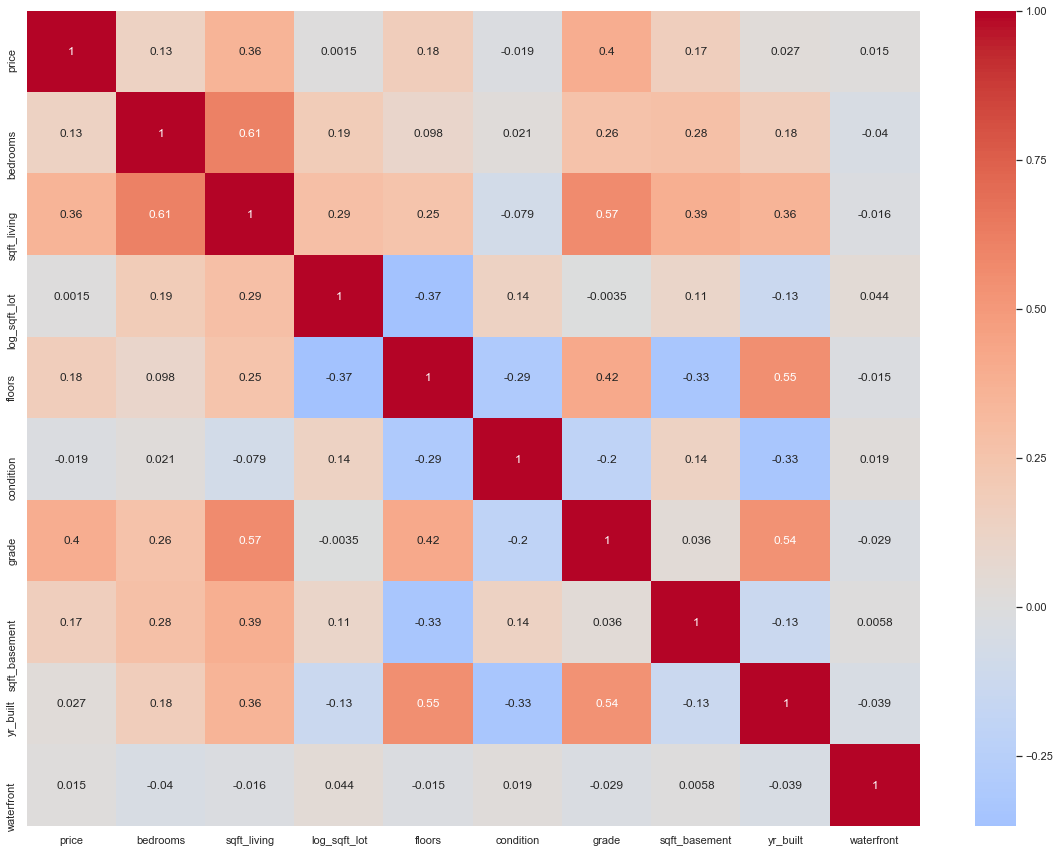

In [36]:
plt.subplots(figsize=(20,15))
sns.heatmap(df[['price', 'bedrooms', 'sqft_living', 'log_sqft_lot', 'floors',
       'condition', 'grade', 'sqft_basement', 'yr_built', 'waterfront']].corr(), 
        center=0,annot=True, cmap='coolwarm')
plt.show()

### Analysis: 
The previous incidents of multicollinearity have been resolved, with no new ones presented.  Even the previous issue with the **grade** variable has resolved.

# Model Creation & Revision

In [37]:
#which columns remain? 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14370 entries, 0 to 21596
Data columns (total 80 columns):
price            14370 non-null float64
bedrooms         14370 non-null int64
bathrooms        14370 non-null float64
sqft_living      14370 non-null int64
floors           14370 non-null float64
waterfront       14370 non-null float64
condition        14370 non-null int64
grade            14370 non-null int64
sqft_basement    14370 non-null float64
yr_built         14370 non-null int64
zip_98002        14370 non-null uint8
zip_98003        14370 non-null uint8
zip_98004        14370 non-null uint8
zip_98005        14370 non-null uint8
zip_98006        14370 non-null uint8
zip_98007        14370 non-null uint8
zip_98008        14370 non-null uint8
zip_98010        14370 non-null uint8
zip_98011        14370 non-null uint8
zip_98014        14370 non-null uint8
zip_98019        14370 non-null uint8
zip_98022        14370 non-null uint8
zip_98023        14370 non-null uint8
zip_980

In [38]:
Y = df.price
features = df.drop(['price'], axis = 1)

I could have used sm.add_constant(features) to make entering the model much easier.  However, that makes the summary much more difficult to interpret.  So, I took the features.columns output above, ran it through a Word find/replace to make the list into the correct format for function below:

In [39]:
formula = 'Y ~ bedrooms + bathrooms + sqft_living + floors + condition + grade \
            + sqft_basement + yr_built + waterfront + log_sqft_lot + zip_98002 \
            + zip_98003 + zip_98004 + zip_98005 + zip_98006 + zip_98007 + zip_98008 \
            + zip_98010 + zip_98011 + zip_98014 + zip_98019 + zip_98022 + zip_98023 \
            + zip_98024 + zip_98027 + zip_98028 + zip_98029 + zip_98030 + zip_98031 \
            + zip_98032 + zip_98033 + zip_98034 + zip_98038 + zip_98039 + zip_98040 \
            + zip_98042 + zip_98045 + zip_98052 + zip_98053 + zip_98055 + zip_98056 \
            + zip_98058 + zip_98059 + zip_98065 + zip_98070 + zip_98072 + zip_98074 \
            + zip_98075 + zip_98077 + zip_98092 + zip_98102 + zip_98103 + zip_98105 \
            + zip_98106 + zip_98107 + zip_98108 + zip_98109 + zip_98112 + zip_98115 \
            + zip_98116 + zip_98117 + zip_98118 + zip_98119 + zip_98122 + zip_98125 \
            + zip_98126 + zip_98133 + zip_98136 + zip_98144 + zip_98146 + zip_98148 \
            + zip_98155 + zip_98166 + zip_98168 + zip_98177 + zip_98178 + zip_98188 \
            + zip_98198 + zip_98199'
model = ols(formula = formula, data = features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     471.4
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:16:54   Log-Likelihood:            -1.7768e+05
No. Observations:               14370   AIC:                         3.555e+05
Df Residuals:                   14291   BIC:                         3.561e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.244e+04   5.98e+04     -0.208      0.835    -1.3e+05    1.05e+05
bedrooms      -4080.7776    761.442     -5.359      0.000   -5573.303   -2588.252
bathrooms      1.359e+04   1227.883     11.068      0.000    1.12e+04     1.6e+04
sqft_living      76.2349      1.558     48.937      0.000      73.181      79.288
floors        -2999.9755   1458.131     -2.057      0.040   -5858.102    -141.849
condition       1.16e+04    842.261     13.769      0.000    9945.992    1.32e+04
grade          2.986e+04    873.229     34.200      0.000    2.82e+04    3.16e+04
sqft_basement   -22.0029      1.823    -12.067      0.000     -25.577     -18.429
yr_built       -154.0724     29.779     -5.174      0.000    -212.443     -95.702
waterfront     9.935e+04    1.4e+04      7.094      0.000    7.19e+04    1.27e+05
log_sqft_lot   2.141e+04    831.209     25.754      0.000    1.98e+04     2.3e+04
zip_98002     -7401.6631   5783.729     -1.280      0.201   -1.87e+04    3935.197
zip_98003      1302.3049   4930.207      0.264      0.792   -8361.541     1.1e+04
zip_98004      2.977e+05   2.86e+04     10.394      0.000    2.42e+05    3.54e+05
zip_98005      2.456e+05   1.06e+04     23.164      0.000    2.25e+05    2.66e+05
zip_98006      1.892e+05   5877.565     32.188      0.000    1.78e+05    2.01e+05
zip_98007      2.101e+05   7200.852     29.173      0.000    1.96e+05    2.24e+05
zip_98008      2.118e+05   5427.876     39.013      0.000    2.01e+05    2.22e+05
zip_98010      5.561e+04   7636.343      7.282      0.000    4.06e+04    7.06e+04
zip_98011      1.502e+05   5550.733     27.065      0.000    1.39e+05    1.61e+05
zip_98014      9.597e+04   6946.267     13.817      0.000    8.24e+04     1.1e+05
zip_98019      9.673e+04   5454.868     17.732      0.000     8.6e+04    1.07e+05
zip_98022      1.029e+04   5235.638      1.965      0.049      24.214    2.05e+04
zip_98023     -1.612e+04   4333.329     -3.720      0.000   -2.46e+04   -7626.700
zip_98024       1.11e+05   8528.327     13.016      0.000    9.43e+04    1.28e+05
zip_98027      1.592e+05   4981.010     31.966      0.000    1.49e+05    1.69e+05
zip_98028      1.323e+05   4928.318     26.841      0.000    1.23e+05    1.42e+05
zip_98029       2.09e+05   5475.237     38.172      0.000    1.98e+05     2.2e+05
zip_98030      7754.4480   4953.350      1.565      0.117   -1954.763    1.75e+04
zip_98031      7602.2387   4826.273      1.575      0.115   -1857.885    1.71e+04
zip_98032     -8914.4051   6485.891     -1.374      0.169   -2.16e+04    3798.784
zip_98033      2.234e+05   5664.673     39.441      0.000    2.12e+05    2.35e+05
zip_98034      1.606e+05   4300.556     37.347      0.000    1.52e+05    1.69e+05
zip_98038      4.326e+04   4133.029     10.467      0.000    3.52e+04    5.14e+04
zip_98039      8.143e-12   6.11e-12      1.334   

## Feature Selection

Running stepwise selection to determine which features should remain in the model:

In [40]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [41]:
result = stepwise_selection(features, Y, verbose=True)
print('resulting features:')
print(result)

/Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Add  sqft_living                    with p-value 0.0
Add  grade                          with p-value 2.54864e-204
Add  yr_built                       with p-value 2.74437e-219
Add  zip_98023                      with p-value 3.36944e-166
Add  zip_98042                      with p-value 2.4272e-91
Add  zip_98003                      with p-value 1.66018e-92
Add  zip_98092                      with p-value 3.19844e-98
Add  zip_98031                      with p-value 1.52645e-88
Add  zip_98030                      with p-value 4.88263e-84
Add  zip_98058                      with p-value 4.81277e-86
Add  zip_98038                      with p-value 6.65491e-84
Add  zip_98002                      with p-value 1.49034e-84
Add  zip_98168                      with p-value 4.31793e-85
Add  zip_98198                      with p-value 2.68383e-90
Add  zip_98032                      with p-value 6.56394e-89
Add  zip_98055                      with p-value 8.6895e-88
Add  zip_98178                 

/Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zip_98118                      with p-value 1.42786e-26
Add  zip_98133                      with p-value 3.20313e-27
Add  zip_98040                      with p-value 6.34701e-25
Add  zip_98028                      with p-value 5.77674e-25
Add  sqft_basement                  with p-value 8.89879e-26
Add  bathrooms                      with p-value 4.54e-24
Add  zip_98155                      with p-value 2.70041e-23
Add  waterfront                     with p-value 4.2166e-15
Add  zip_98004                      with p-value 1.05344e-12
Add  zip_98108                      with p-value 1.29585e-10
Add  zip_98077                      with p-value 2.50369e-10
Add  zip_98106                      with p-value 9.40805e-10
Add  zip_98059                      with p-value 1.87813e-10
Add  zip_98056                      with p-value 1.93469e-09
Add  zip_98166                      with p-value 9.2901e-12
Add  zip_98019                      with p-value 2.28458e-13
Add  zip_98045               

## Re-fit the Model with Selected Features

1. Create a new set of features from those selected in the stepwise selection
2. Re-fit the model

In [42]:
selected_features = features.filter(['sqft_living', 'sqft_basement', 'grade', 'condition', 
                                     'yr_built', 'bedrooms', 'bathrooms',  'log_sqft_lot', 
                                     'waterfront','zip_98023', 'zip_98092', 'zip_98038', 
                                     'zip_98002', 'zip_98032', 'zip_98117', 'zip_98107', 
                                     'zip_98115', 'zip_98105', 'zip_98103', 'zip_98116', 
                                     'zip_98052', 'zip_98033', 'zip_98199', 'zip_98053', 
                                     'zip_98008', 'zip_98029', 'zip_98122', 'zip_98136', 
                                     'zip_98119', 'zip_98112', 'zip_98074', 'zip_98144', 
                                     'zip_98102', 'zip_98075', 'zip_98006', 'zip_98034', 
                                     'zip_98007', 'zip_98125', 'zip_98005', 'zip_98027', 
                                     'zip_98126', 'zip_98109', 'zip_98177', 'zip_98065', 
                                     'zip_98072', 'zip_98011', 'zip_98118', 'zip_98133', 
                                     'zip_98040', 'zip_98028',  'zip_98155','zip_98004', 
                                     'zip_98108', 'zip_98077', 'zip_98106', 'zip_98059', 
                                     'zip_98056', 'zip_98166', 'zip_98019', 'zip_98045', 
                                     'zip_98146', 'zip_98014', 'zip_98070', 'zip_98024',  
                                     'zip_98178', 'zip_98058', 'zip_98055', 'zip_98010', 
                                     'zip_98198', 'zip_98168', 'zip_98148', 'zip_98188'], 
                                    axis = 1)

Taking the above columns, search/replace in Word, and then introducing them as the set of features when revising the model:

In [43]:
formula = 'Y ~ sqft_living + sqft_basement + grade + condition + yr_built + \
            bedrooms + bathrooms + log_sqft_lot + waterfront + zip_98023 + zip_98092 \
            + zip_98038 + zip_98002 + zip_98032 + zip_98117 + zip_98107 + zip_98115 \
            + zip_98105 + zip_98103 + zip_98116 + zip_98052 + zip_98033 + zip_98199 \
            + zip_98053 + zip_98008 + zip_98029 + zip_98122 + zip_98136 + zip_98119 \
            + zip_98112 + zip_98074 + zip_98144 + zip_98102 + zip_98075 + zip_98006 \
            + zip_98034 + zip_98007 + zip_98125 + zip_98005 + zip_98027 + zip_98126 \
            + zip_98109 + zip_98177 + zip_98065 + zip_98072 + zip_98011 + zip_98118 \
            + zip_98133 + zip_98040 + zip_98028 + zip_98155 + zip_98004 + zip_98108 \
            + zip_98077 + zip_98106 + zip_98059 + zip_98056 + zip_98166 + zip_98019 \
            + zip_98045 + zip_98146 + zip_98014 + zip_98070 + zip_98024 + zip_98178 \
            + zip_98058 + zip_98055 + zip_98010 + zip_98198 + zip_98168 + zip_98148 \
            + zip_98188'
model = ols(formula = formula, data = selected_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     510.2
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:18:28   Log-Likelihood:            -1.7768e+05
No. Observations:               14370   AIC:                         3.555e+05
Df Residuals:                   14297   BIC:                         3.561e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9679.4195   5.82e+04      0.166      0.868   -1.04e+05    1.24e+05
sqft_living      75.4073      1.493     50.522      0.000      72.482      78.333
sqft_basement   -20.3672      1.575    -12.928      0.000     -23.455     -17.279
grade          2.977e+04    871.936     34.144      0.000    2.81e+04    3.15e+04
condition      1.184e+04    838.938     14.116      0.000    1.02e+04    1.35e+04
yr_built       -165.7919     28.658     -5.785      0.000    -221.966    -109.618
bedrooms      -4078.8838    761.074     -5.359      0.000   -5570.688   -2587.080
bathrooms      1.311e+04   1201.253     10.912      0.000    1.08e+04    1.55e+04
log_sqft_lot   2.202e+04    790.423     27.856      0.000    2.05e+04    2.36e+04
waterfront     9.885e+04    1.4e+04      7.058      0.000    7.14e+04    1.26e+05
zip_98023     -2.252e+04   3103.723     -7.257      0.000   -2.86e+04   -1.64e+04
zip_98092     -1.033e+04   3514.924     -2.938      0.003   -1.72e+04   -3436.884
zip_98038      3.639e+04   2825.396     12.879      0.000    3.08e+04    4.19e+04
zip_98002     -1.402e+04   4930.732     -2.844      0.004   -2.37e+04   -4358.545
zip_98032     -1.565e+04   5739.870     -2.726      0.006   -2.69e+04   -4397.838
zip_98117      2.472e+05   3619.080     68.313      0.000     2.4e+05    2.54e+05
zip_98107      2.689e+05   4699.440     57.226      0.000     2.6e+05    2.78e+05
zip_98115      2.399e+05   3678.221     65.227      0.000    2.33e+05    2.47e+05
zip_98105      2.902e+05   6566.027     44.202      0.000    2.77e+05    3.03e+05
zip_98103      2.296e+05   3648.214     62.941      0.000    2.22e+05    2.37e+05
zip_98116      2.433e+05   4497.424     54.101      0.000    2.35e+05    2.52e+05
zip_98052      2.017e+05   3768.566     53.517      0.000    1.94e+05    2.09e+05
zip_98033      2.167e+05   4791.277     45.236      0.000    2.07e+05    2.26e+05
zip_98199      2.585e+05   5586.483     46.273      0.000    2.48e+05    2.69e+05
zip_98053      1.914e+05   4492.294     42.611      0.000    1.83e+05       2e+05
zip_98008      2.056e+05   4502.262     45.658      0.000    1.97e+05    2.14e+05
zip_98029      2.019e+05   4560.924     44.269      0.000    1.93e+05    2.11e+05
zip_98122      2.309e+05   5000.457     46.179      0.000    2.21e+05    2.41e+05
zip_98136      2.058e+05   4595.451     44.792      0.000    1.97e+05    2.15e+05
zip_98119      2.722e+05   8671.080     31.389      0.000    2.55e+05    2.89e+05
zip_98112      2.741e+05   9047.194     30.295      0.000    2.56e+05    2.92e+05
zip_98074      1.812e+05   4480.167     40.444      0.000    1.72e+05     1.9e+05
zip_98144      1.864e+05   4237.540     43.996      0.000    1.78e+05    1.95e+05
zip_98102       2.76e+05   1.08e+04     25.533      0.000    2.55e+05    2.97e+05
zip_98075      2.056e+05   7300.919     28.161   

### Model Validation

In [44]:
five_folds = cross_val_score(linreg, selected_features, Y, cv=5, 
                             scoring='neg_mean_squared_error')
print(five_folds)

[-3.17280211e+09 -3.35262757e+09 -3.19387561e+09 -3.33541757e+09
 -3.35175461e+09]


In [45]:
df_folds = pd.DataFrame(five_folds)
df_folds.describe()

,0
count,5.000000e+00
mean,-3.281295e+09
std,8.999306e+07
min,-3.352628e+09
25%,-3.351755e+09
50%,-3.335418e+09
75%,-3.193876e+09
max,-3.172802e+09


### Model Review:

The model shows a positive linear relationship between price and livable square feet, grade, condition, the number of bathrooms, lot size and whether they abutted water.  Generically, houses started at \\$75.41 per square foot; various zip codes then provided a positive or negative component (though some were dropped during the feature selection phase).  Waterfront properties enjoyed a nearly \\$100,000 premium, based purely upon whether they abutted the water.  

Grade and condition also provided a significant premium.  Condition ranged from 1-5, with an approximately \\$30,000 premium for each step up.  Grade had many more levels, ranging from 1-13, and had a lower premium for each step (\\$11,840 per step). 

Older houses were valued less; they had a negative effect on price.  

Curiously, bedrooms have an inverse relationship with price.  I'm not sure how to explain this one; it seems counterintuitive. 

However, looking at the model statistics, there are two significant issues: the very high Omnibus (549.6) and the very high Condition (3.33e+05).  Omnibus is difficult to address because it's nonspecific. The high Condition, though, can be an indication of significant multicollinearity. 

The best resource I've found for interpreting Statsmodels' OLS report is linked below.  
https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

Five fold validation is reassuring, given the negative mean squared errors scores are pretty consistent. 